# INSTALL DEPENDENCIES

In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import cv2

In [242]:
colorImgBgr = cv2.imread(r'../../Downloads/download.png')
grayImg = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)
grayAlb = cv2.imread(r'../../Downloads/albert-einstein_gray.jpg', cv2.IMREAD_GRAYSCALE)
grayAlbAffine = cv2.imread(r'../../Downloads/affine-transformed image.jpg', cv2.IMREAD_GRAYSCALE)
grayAlProjective = cv2.imread(r'../../Downloads/albert-einstein_Projective_warped.jpg', cv2.IMREAD_GRAYSCALE)
grayImgAffine = cv2.imread(r'../../Downloads/puppy-projective.jpeg', cv2.IMREAD_GRAYSCALE)

In [198]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

# BILINEAR TRANSFORMATION

In [199]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthBottom * a
        return np.uint8(g)
    else:
        return 0

# ROTATION IMPLEMENTATION

In [200]:
def f_getExtents(T, rMax, cMax):
    coords = np.array([[0,0], [0, cMax - 1], [rMax - 1, 0], [rMax - 1, cMax -1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [201]:
def f_transform(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# AFFINE TRANSFORMATION

In [202]:
def f_getExtentsAffine(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [203]:
def f_transformAffine(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# PROJECTIVE TRANSFORMATION HOMOGRAPHY

In [204]:
def f_getExtentsProjective(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [205]:
def f_transformProjective(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsProjective(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

In [206]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
H = np.array(A)
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [207]:
H[2,:] = np.array([0.0001, 0.0001, 1])
H

array([[ 1.12583302e+00, -8.70834875e-02, -2.91651246e+00],
       [ 3.50000000e-01,  7.81217783e-01, -1.74871131e+01],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e+00]])

In [208]:
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [209]:
I2 = f_transformProjective(H,grayAlb)
plt.imshow(I2,cmap='gray')

In [210]:
def f_getPoints(I,numPts):
    %matplotlib
    fig,ax = plt.subplots(1,figsize=(15,30))
    plt.imshow(I,cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts)))
    pts = pts[:,[1,0]].T
    plt.close()
    return pts

In [211]:
pts = f_getPoints(grayImg, 4)
#pts = np.array([[397., 387., 477., 631.], [317., 389., 440., 412.]])

Using matplotlib backend: QtAgg


In [213]:
P = f_getPoints(grayImg, 3)

Using matplotlib backend: QtAgg


In [214]:
P

array([[ 99.,  92., 192.],
       [ 88., 168., 119.]])

In [215]:
P_dash = f_getPoints(grayImgAffine, 3)

Using matplotlib backend: QtAgg


In [216]:
P_dash

array([[ 94.,  81., 145.],
       [ 82., 122., 106.]])

In [217]:
P = np.vstack((P,np.ones((1,3))))

In [218]:
P

array([[ 99.,  92., 192.],
       [ 88., 168., 119.],
       [  1.,   1.,   1.]])

In [219]:
P_dash = np.vstack((P_dash,np.ones((1,3))))

In [220]:
np.linalg.det(P)

-7657.000000000002

In [221]:
A = P_dash.dot(np.linalg.inv(P))

In [222]:
A

array([[ 5.85477341e-01, -1.11270733e-01,  4.58295677e+01],
       [ 8.88076270e-02,  5.07770667e-01,  2.85242262e+01],
       [ 1.73472348e-18,  4.33680869e-19,  1.00000000e+00]])

In [223]:
I2=f_transformProjective(A,grayImg)

In [224]:
plt.imshow(I2,cmap='gray')

In [225]:
plt.imshow(grayImgAffine,cmap='gray')

In [226]:
P = f_getPoints(grayAlb, 5)

Using matplotlib backend: QtAgg


In [227]:
P

array([[  6.,  12., 942., 945., 481.],
       [  4., 724., 724.,   4., 438.]])

In [228]:
P_dash =  f_getPoints(grayAlbAffine, 5)

Using matplotlib backend: QtAgg


In [229]:
P_dash

array([[ 61.,   7., 889., 943., 481.],
       [  5., 454., 718., 272., 416.]])

In [230]:
P = np.vstack((P,np.ones((1,5))))

In [231]:
P

array([[  6.,  12., 942., 945., 481.],
       [  4., 724., 724.,   4., 438.],
       [  1.,   1.,   1.,   1.,   1.]])

In [232]:
P_dash = np.vstack((P_dash,np.ones((1,5))))

In [233]:
P_dash

array([[ 61.,   7., 889., 943., 481.],
       [  5., 454., 718., 272., 416.],
       [  1.,   1.,   1.,   1.,   1.]])

In [234]:
A = P_dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T)))

In [235]:
A

array([[ 9.43828449e-01, -7.61495818e-02,  5.46505255e+01],
       [ 2.84137222e-01,  6.21666351e-01,  1.92250363e+00],
       [ 5.42101086e-19, -1.08420217e-19,  1.00000000e+00]])

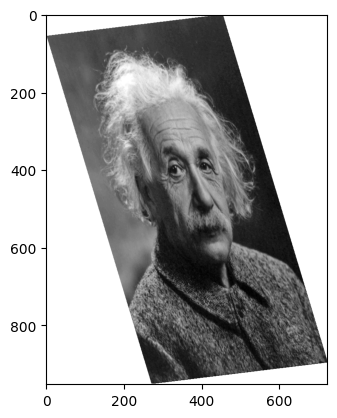

In [236]:
I2=f_transformProjective(A,grayAlb)
%matplotlib inline
plt.imshow(I2, cmap='gray')

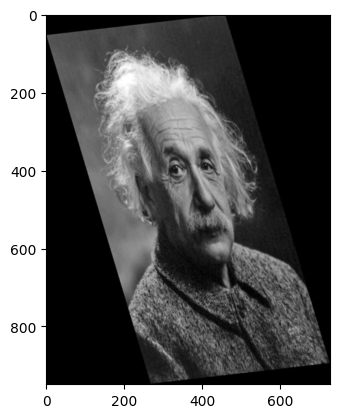

In [237]:
plt.imshow(grayAlbAffine, cmap='gray')

In [238]:
I2=f_transformProjective(A,grayImg)

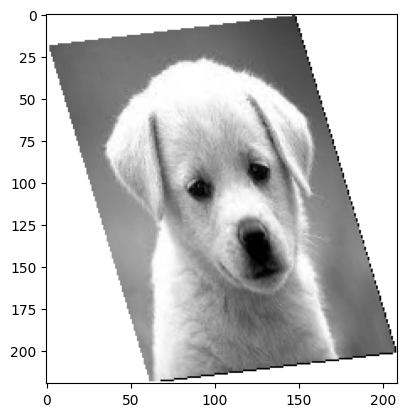

In [239]:
plt.imshow(I2, cmap='gray')

In [240]:
def f_computeRightNullSpace(A):
    B = A.T.dot(A)
    w, v = np.linalg.eig(B)
    idx = np.argmin(w)
    nullVector = v[:, idx]
    return nullVector

A = np.random.rand(3,4)
nv = f_computeRightNullSpace(A)
nv

array([ 0.09589394,  0.07774031, -0.45674133,  0.88099271])

In [241]:
A.dot(nv)

array([-1.38777878e-17, -8.32667268e-17, -5.55111512e-17])

# DLT implementation

In [258]:
P = f_getPoints(grayImg, 4)
P_dash = f_getPoints(grayImgAffine, 4)
P = np.vstack((P, np.ones((1, 4))))
P_dash = np.vstack((P_dash, np.ones((1, 4))))
A = np.zeros((8, 9))
A[::2, :3] = -P.T
A[1::2, 3:6] = -P.T

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg


In [259]:
A

array([[  -1.,   -1.,   -1.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   -1.,   -1.,   -1.,    0.,    0.,    0.],
       [  -1., -235.,   -1.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   -1., -235.,   -1.,    0.,    0.,    0.],
       [-212., -235.,   -1.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0., -212., -235.,   -1.,    0.,    0.,    0.],
       [-212.,   -1.,   -1.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0., -212.,   -1.,   -1.,    0.,    0.,    0.]])

In [260]:
A[::2,6:] = P.dot(np.diag(P_dash[0,:])).T

In [261]:
A

array([[-1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.7000e+01,  1.7000e+01,  1.7000e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-1.0000e+00, -2.3500e+02, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.0000e+00,  4.7000e+02,  2.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00, -2.3500e+02,
        -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-2.1200e+02, -2.3500e+02, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.9468e+04,  3.2665e+04,  1.3900e+02],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1200e+02, -2.3500e+02,
        -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-2.1200e+02, -1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.6040e+04,  1.7000e+02,  1.7000e+02],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1200e+02, -1

In [262]:
A[1::2,6:] = P.dot(np.diag(P_dash[1,:])).T

In [263]:
A

array([[-1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.7000e+01,  1.7000e+01,  1.7000e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00,  3.0000e+00,  3.0000e+00,  3.0000e+00],
       [-1.0000e+00, -2.3500e+02, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.0000e+00,  4.7000e+02,  2.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00, -2.3500e+02,
        -1.0000e+00,  1.5200e+02,  3.5720e+04,  1.5200e+02],
       [-2.1200e+02, -2.3500e+02, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.9468e+04,  3.2665e+04,  1.3900e+02],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1200e+02, -2.3500e+02,
        -1.0000e+00,  3.2436e+04,  3.5955e+04,  1.5300e+02],
       [-2.1200e+02, -1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.6040e+04,  1.7000e+02,  1.7000e+02],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1200e+02, -1

In [250]:
h = f_computeRightNullSpace(A)

In [251]:
h

array([-2.08917129e-02,  1.54259887e-03, -9.98885560e-01, -6.54676692e-03,
       -1.33967295e-02, -3.55874414e-02, -1.79107666e-05, -1.38487962e-06,
       -1.73203626e-02])

In [252]:
H = np.reshape(h, (3,3))

In [253]:
H

array([[-2.08917129e-02,  1.54259887e-03, -9.98885560e-01],
       [-6.54676692e-03, -1.33967295e-02, -3.55874414e-02],
       [-1.79107666e-05, -1.38487962e-06, -1.73203626e-02]])

In [256]:
I2 = f_transformProjective(H, grayAlb)

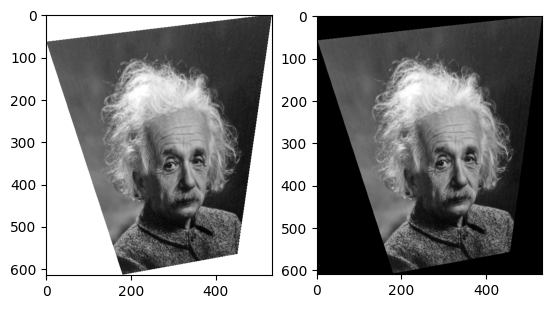

In [257]:
plt.figure(1)
%matplotlib inline
plt.subplot(121)
plt.imshow(I2, cmap='gray')
plt.subplot(122)
plt.imshow(grayAlProjective, cmap='gray')
plt.show()